In [1]:
"""
References: 
1) https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
2) https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
3) King's College London Keras Instruction Tutorial PDF
4) https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
""" 

"\nReferences: \n1) https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/\n2) https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/\n3) King's College London Keras Instruction Tutorial PDF\n4) https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e\n"

In [2]:
#change width of Jupyer Notebook to use the whole window
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))     

C:\Users\cipri\AppData\Local\Temp\ipykernel_33344\4283796252.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------LIBRARIES---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
from tensorflow.keras.datasets            import mnist
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers          import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#----------------------------------------------------------------------------------------------METRICS----------------------------------------------------------------------------------------------
from sklearn.model_selection import KFold
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import cohen_kappa_score
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

#---------------------------------------------------------------------------------------CUDA RESOURCE CONTROL---------------------------------------------------------------------------------------
from numba import cuda

#--------------------------------------------------------------------------------------------STATISTICS---------------------------------------------------------------------------------------------
import statistics

#---------------------------------------------------------------------------------------CUDA RESOURCE CONTROL---------------------------------------------------------------------------------------
import numpy as np
from numpy import mean
from numpy import std

from matplotlib import pyplot as plt

In [4]:
# import libraries to check available training devices
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import mixed_precision

# list available devices
print(device_lib.list_local_devices())

# GPU performance optimisations - only works with XLA devices on non-windows machines
# tf.function(jit_compile=True)                                   

# # makes use of the tensor cores available on RTX cards
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# # print compute and variable precision 
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4344193610832811327
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22385000448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11116609025585100581
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:31:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [5]:
# load dataset and perform split
def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()                      # load dataset
    
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))                      # reshape X_train to have a single channel 28x28 img representation
    X_test  = X_test.reshape((X_test.shape[0], 28, 28, 1))                        # reshape X_test to have a single channel 28x28 img representation
    
    y_train = to_categorical(y_train)                                             # one hot encode train labels
    y_test  = to_categorical(y_test)                                              # one hot encode test labels
        
    return X_train, y_train, X_test, y_test

# perform data augmentation on the original X_train
def data_augmentation(train_data, train_labels, rot, zoom, width, height):
    datagen = ImageDataGenerator(rotation_range     = rot,  
                                 zoom_range         = zoom,  
                                 width_shift_range  = width, 
                                 height_shift_range = height)
    datagen.fit(train_data)
    aug_data = datagen.flow(train_data, train_labels)
    
    return aug_data

# process dataset by changing 255 integers to float 0.0-1.0 values
def prep_pixels(train, test):
    train_float = train.astype('float32') / 255.0                                 # normalize to range 0-1
    test_float  = test.astype('float32') / 255.0                                  # normalize to range 0-1
     
    return train_float, test_float                                                # return normalized images


In [6]:
# define CNN network
def define_cnn():
    CNN = Sequential()
    CNN.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(64,kernel_size=3,activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.4))
    
    CNN.add(Conv2D(128,kernel_size=3,activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(128,kernel_size=3,activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(128,kernel_size=5,strides=2,padding='same',activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.4))
    
    CNN.add(Flatten())
    CNN.add(Dense(128, activation='relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.4))
    CNN.add(Dense(10, activation='softmax'))
    
    # compile model
    CNN.compile(optimizer="adam", 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
    CNN.summary()
    
    # return defined cnn
    return CNN

# train CNN network
def train_model(augmented_data, X_test, y_test, n_epochs, b_size):
    # fit model
    cnn_model = define_cnn()                                      
    history = cnn_model.fit(augmented_data, 
                            epochs = n_epochs, 
                            batch_size = b_size, 
                            validation_data=(X_test, y_test), 
                            verbose=1)
    
    return cnn_model, history
    

In [7]:
# evaluate a model using k-fold cross-validation
def evaluate_model(X_data, y_data, n_folds, n_epochs, b_size):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle = True, random_state = 1)                      # prepare cross validation
    
    for train_ix, test_ix in kfold.split(X_data):                                 # enumerate splits
        X_train, y_train = X_data[train_ix], y_data[train_ix]                     # select rows for training
        X_test, y_test   = X_data[test_ix], y_data[test_ix]                       # select rows for testing
        
        cnn_model, history = train_model(X_train, y_train, 
                                         X_test, y_test, 
                                         n_folds, n_epochs)

        # stores scores
        _, acc = cnn_model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        scores.append(accuracy)
        histories.append(history)
        
    return scores, histories                                                      # return evaluation   
    
# performance metrics
def performance(X_test, y_test, model):
        # evaluate model
        yhat_probs = model.predict(X_test, verbose=0)                             # predict probabilities for test set
        yhat_classes = np.argmax(yhat_probs, axis=1)                              # predict crisp classes for test set 
        y_test = np.argmax(y_test, axis=1)
        
        #print(y_test)
        #print(yhat_classes)
        
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_test, yhat_classes)*100
        print('Accuracy: %f' % accuracy)
        
        # precision tp / (tp + fp)
        precision = precision_score(y_test, yhat_classes, average = None)*100
        print("Precision: ", statistics.fmean(precision))
        print(", ".join('{:0.2f}'.format(i) for i in precision))
        
        # recall: tp / (tp + fn)
        recall = recall_score(y_test, yhat_classes, average = None)*100
        print("Recall: ", statistics.fmean(recall))
        print(", ".join('{:0.2f}'.format(i) for i in recall))
        
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_test, yhat_classes, average = None)*100
        print("F1 Score: ", statistics.fmean(f1))
        print(", ".join('{:0.2f}'.format(i) for i in f1))
        
        # kappa
        kappa = cohen_kappa_score(y_test, yhat_classes)*100
        print('Cohens kappa: %f' % kappa)
        
        # confusion matrix
        cm = confusion_matrix(y_test, yhat_classes)
        labels = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
        cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                         display_labels = labels)
        cm_plot.plot()
        plt.show()

# plot diagnostic learning curves
def summarize_diagnostics(history):
    if type(history) == list:
        for i in range(len(history)):
            # plot loss
            plt.subplot(2, 1, 1)
            plt.title('Cross Entropy Loss')
            plt.plot(history[i].history['loss'], color='blue', label='train')
            plt.plot(history[i].history['val_loss'], color='orange', label='test')

            # plot accuracy
            plt.subplot(2, 1, 2)
            plt.title('Classification Accuracy')
            plt.plot(history[i].history['accuracy'], color='blue', label='train')
            plt.plot(history[i].history['val_accuracy'], color='orange', label='test')
            plt.show()
            
    else:
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')

        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.show()
        
# display performance summary
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % 
          (mean(scores)*100, std(scores)*100, len(scores))) 
    
    plt.boxplot(scores)                                                           # box and whisker plots of results
    plt.show()                                                                    # display results

def main_code():
    with tf.device('/device:GPU:0'):
        # training parameters
        EPOCHS  = 98
        BATCHES = 32
        
        # data augmentation parameters
        ROTATION_RANGE = 10
        ZOOM_RANGE     = 0.10
        WIDTH_RANGE    = 0.10
        HEIGHT_RANGE   = 0.10
        
        # calling functions to load, prepare and augment the data
        X_train, y_train, X_test, y_test = load_dataset()                         # load dataset
        X_train, X_test = prep_pixels(X_train, X_test)                            # prepare pixel data
        augmented_data = data_augmentation(X_train, y_train, 
                                           ROTATION_RANGE, 
                                           ZOOM_RANGE,
                                           WIDTH_RANGE, 
                                           HEIGHT_RANGE)

        # k-fold functions for model testing
        #scores, history = evaluate_model(X_train, y_train, 5, EPOCHS, BATCHES)   # evaluate model
        #summarize_performance(scores)                                            # summarize estimated performance
        
        # train model
        cnn_model, history = train_model(augmented_data, 
                                         X_test, y_test, 
                                         EPOCHS, 
                                         BATCHES)
        
        # save model
        cnn_model.save("cnn_trained_mnist.h5")
        
        # get performance metrics
        performance(X_test, y_test, cnn_model)
        summarize_diagnostics(history)                                            # display learning curves
        
        # release allocated resources after termination
        tf.keras.backend.clear_session()
        cuda.select_device(0)
        cuda.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        102464    
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 64)       2

1875/1875 [==============================] - 38s 20ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0124 - val_accuracy: 0.9958
Epoch 34/98
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.0128 - val_accuracy: 0.9965
Epoch 35/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0122 - val_accuracy: 0.9960
Epoch 36/98
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0120 - val_accuracy: 0.9963
Epoch 37/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0133 - val_accuracy: 0.9960
Epoch 38/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0126 - val_accuracy: 0.9962
Epoch 39/98
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0164 - val_

Epoch 89/98
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.0149 - val_accuracy: 0.9955
Epoch 90/98
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0164 - val_accuracy: 0.9958
Epoch 91/98
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0156 - val_accuracy: 0.9966
Epoch 92/98
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0175 - val_accuracy: 0.9960
Epoch 93/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0177 - val_accuracy: 0.9955
Epoch 94/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0148 - val_accuracy: 0.9959
Epoch 95/98
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0

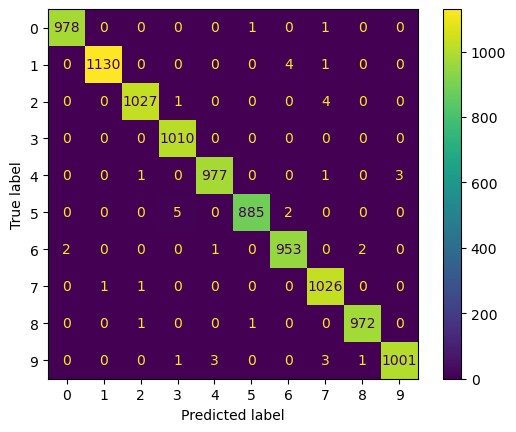

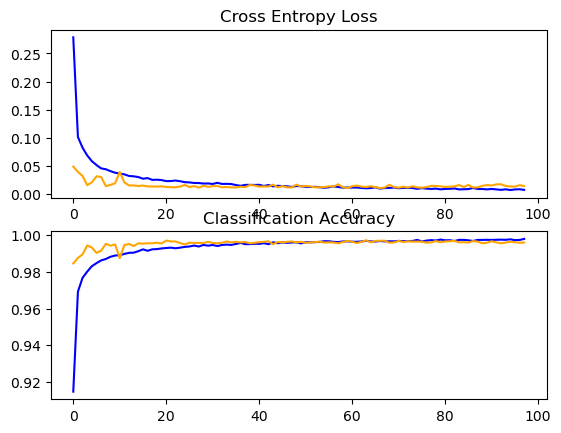

In [8]:
# guard boilerplate
if __name__ == "__main__":  
    main_code()